In [ ]:
import uproot
import pandas as pd
import numpy as np
import json
import dill
from numpy import  log, sqrt, exp, pi, e
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from source import *
from numba import njit
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns

In [6]:
data = pd.read_parquet("data.parquet")

In [7]:
data

,__experiment__,__run__,__event__,__production__,missedE,M0,p0,recM2,idec0,idec1,...,E_gamma_in_ROE,is0,correct_nu_0,correct_nu_1,correct_gamma_0,correct_gamma_1,lost_0,lost_1,N_KL,Bs_lik
0,67,0,3,0.0,5.152812,5.370515,0.506960,26.133972,2,NaN,...,2.102357,1.0,False,False,True,False,True,False,NaN,NaN
1,67,0,3,0.0,4.412598,5.370515,0.506960,18.203999,3,NaN,...,1.199150,1.0,True,False,True,False,True,False,NaN,NaN
2,67,0,3,0.0,4.300276,5.370515,0.506960,18.016747,3,NaN,...,1.344219,1.0,False,False,False,False,False,False,NaN,NaN
3,67,0,3,0.0,4.634762,5.370515,0.506960,21.168146,3,NaN,...,1.640865,1.0,False,False,False,False,False,False,NaN,NaN
4,67,0,3,0.0,4.649901,5.370515,0.506960,21.279388,3,NaN,...,1.748111,1.0,False,False,False,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35801,43,1016,108539,NaN,2.863387,5.359181,0.451109,6.308968,3,4.0,...,0.368225,0.0,False,False,True,False,True,False,1.0,0.000205
15041,43,1028,92255,NaN,3.653078,5.354310,0.500539,10.597582,5,4.0,...,1.698012,0.0,False,False,False,False,True,False,0.0,0.000118
5435,43,1024,2802,NaN,2.219670,5.442883,0.455433,2.919562,4,4.0,...,0.765907,0.0,False,False,False,False,False,False,1.0,0.000385
49292,43,1031,132975,NaN,3.941541,5.505877,0.415257,15.218904,4,5.0,...,3.056571,0.0,False,False,False,False,False,False,2.0,0.000685


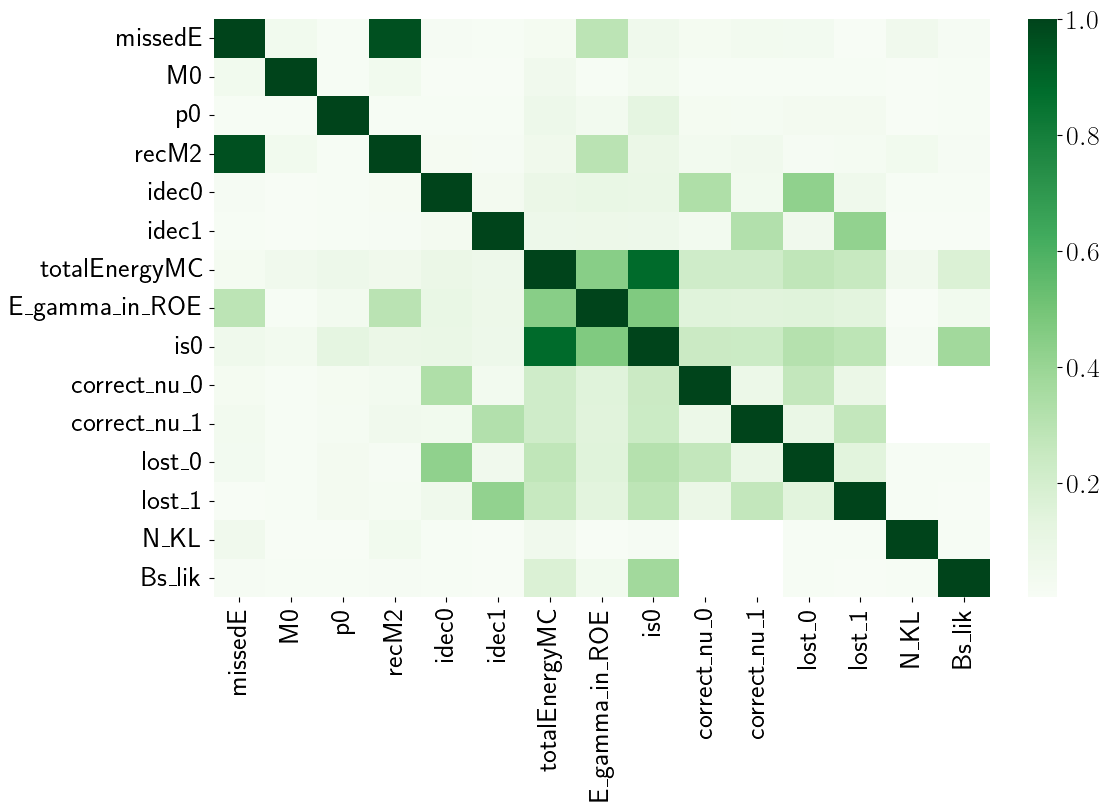

In [ ]:
rs = np.random.RandomState(0)
df= data.iloc[: , [4,5,6,7,8,9,10,11,12,13,14,17,18,19,20]].copy()
corr = df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(np.abs(corr), cmap="Greens")
plt.show()

In [ ]:
data.corr()

,__experiment__,__run__,__event__,__production__,missedE,M0,p0,recM2,idec0,idec1,...,E_gamma_in_ROE,is0,correct_nu_0,correct_nu_1,correct_gamma_0,correct_gamma_1,lost_0,lost_1,N_KL,Bs_lik
__experiment__,167.186567,-6.595000e+03,-9.340108e+05,0.0,-0.647763,-0.027091,-0.064345,-6.521346,-1.452038,-1.082446,...,-6.138229,6.241379,0.757861,0.736463,0.907651,0.773237,1.981887,1.813343,0.000000,0.000000
__run__,-6595.000169,2.617188e+05,3.707426e+07,0.0,25.561553,1.073967,2.631895,257.763284,57.699077,43.013909,...,243.433170,-247.625031,-29.998169,-29.223403,-36.111717,-30.766128,-78.677371,-71.949959,0.017500,-0.000574
__event__,-934010.824547,3.707426e+07,1.350793e+10,0.0,673.730434,152.977041,361.972107,15944.552377,8128.697218,6511.247704,...,36472.783502,-35959.759827,-4248.434509,-4138.908919,-5061.663476,-4277.353246,-10983.271505,-10046.493029,1758.880935,-180.604342
__production__,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
missedE,-0.647763,2.556155e+01,6.737304e+02,0.0,0.725980,-0.002076,-0.000362,4.652362,0.015653,0.010363,...,0.246082,-0.024253,-0.005737,-0.008058,-0.012532,-0.021670,0.014476,-0.001251,0.030821,-0.000221
M0,-0.027091,1.073967e+00,1.529770e+02,0.0,-0.002076,0.002911,-0.000025,-0.013423,0.000138,0.000156,...,0.000336,-0.001080,-0.000128,-0.000131,-0.000008,-0.000044,-0.000236,-0.000269,-0.000336,-0.000012
p0,-0.064345,2.631895e+00,3.619721e+02,0.0,-0.000362,-0.000025,0.003691,-0.002219,0.000470,0.000447,...,0.002349,-0.003861,-0.000378,-0.000327,-0.000414,-0.000433,-0.000978,-0.000968,-0.000167,-0.000007
recM2,-6.521346,2.577633e+02,1.594455e+04,0.0,4.652362,-0.013423,-0.002219,32.141426,0.137488,0.093669,...,1.671085,-0.244975,-0.050592,-0.066365,-0.116662,-0.180207,0.042208,-0.069295,0.191094,-0.001816
idec0,-1.452038,5.769908e+01,8.128697e+03,0.0,0.015653,0.000138,0.000470,0.137488,1.379464,0.041244,...,0.115153,-0.054895,-0.091580,-0.011449,-0.227581,-0.022530,-0.242568,-0.033187,0.005421,-0.000212
idec1,-1.082446,4.301391e+01,6.511248e+03,0.0,0.010363,0.000156,0.000447,0.093669,0.041244,1.382361,...,0.086913,-0.041409,-0.010483,-0.088599,-0.018012,-0.228339,-0.027985,-0.238688,0.004025,-0.000081


In [9]:
import re
import json
from functools import reduce
from copy import deepcopy
from itertools import product
import pandas as pd

In [10]:

def make_anti(particle: str) -> str:
    #print(particle)
    wronf_p = {"anti-Lambda_c-": "Lambda_c+", "Lambda_c(2593)+":"anti-Lambda_c(2593)-", "Lambda_c(2625)+":"anti-Lambda_c(2625)-"}
    if particle in wronf_p:
        return wronf_p[particle]
    if particle in ["pi0", "rho0", "K_S0"]:
        return particle
    if particle.endswith("+"):
        return particle[:-1] + "-"
    if particle.endswith("-"):
        return particle[:-1] + "+"
    if "0" in particle:
        if particle.startswith("anti-"):
            return particle[5:]
        return "anti-" + particle
    return particle


In [11]:
print(make_anti("anti-D0"))

D0


In [12]:
def parse_decay_block(text: str) -> dict[str, list[dict]]:
    """
    Парсит текст в формате DECAY BLOCK в словарь с продуктами, BR и моделью.
    Также обрабатывает директиву CDecay для автогенерации сопряжённых распадов.
    """
    decay_dict = {}
    current_decay = None
    cdecay_links = []

    MODEL_KEYWORDS = {
        'PHOTOS', 'ISGW2', 'PHSP', 'SVS', 'STS', 'PYTHIA',
        'TAULNUNU', 'TAUSCALARNU', 'TAUVECTORNU',
        'SVV_HELAMP', 'VSP_PWAVE'
    }

    for line in text.splitlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue

        if line.startswith("Decay"):
            parts = line.split()
            if len(parts) > 1:
                current_decay = parts[1]
                decay_dict[current_decay] = []
            continue

        if line.startswith("CDecay"):
            parts = line.split()
            if len(parts) > 1:
                cdecay_links.append(parts[1])
            continue

        if line.startswith("Enddecay"):
            current_decay = None
            continue

        if current_decay:
            line = re.sub(r'#.*', '', line)
            line = line.rstrip(';')
            tokens = line.split()

            if len(tokens) < 2:
                continue

            try:
                br = float(tokens[0])
            except ValueError:
                continue

            model_start = next(
                (i for i, t in enumerate(tokens[1:], 1)
                 if re.fullmatch(r'[A-Z0-9_]+', t) and t in MODEL_KEYWORDS),
                len(tokens)
            )

            products = tokens[1:model_start]
            model = ' '.join(tokens[model_start:])

            decay_dict[current_decay].append({
                'branching_ratio': br,
                'products': products,
                'model': model
            })

    for anti_particle in cdecay_links:

        orig_particle = make_anti(anti_particle)


        anti_decays = []
        for decay in decay_dict[orig_particle]:
            anti_products = [make_anti(p) for p in decay["products"]]
            anti_decays.append({
                'branching_ratio': decay['branching_ratio'],
                'products': anti_products,
                'model': decay['model']
            })
        decay_dict[anti_particle] = anti_decays

    return decay_dict


In [13]:

text_data2 = str()
with open("DECAY_1.DEC", "r") as outfile:
    text_data2 = reduce(lambda x, y: x +y, [i for i in outfile.readlines()])

In [14]:
decays2 = parse_decay_block(text_data2)
dec_filter  = {}

In [15]:
for part in decays2:
    for dec in  decays2[part]:
        if dec["branching_ratio"] > 0.0005:
            try:
                dec_filter[part].append(dec) 
            except:
                dec_filter[part] = []
    


In [16]:
def decay_dict_to_text(decay_dict: dict) -> str:
    lines = []
    for particle, decays in decay_dict.items():
        lines.append(f"Decay {particle}")
        for decay in decays:
            br = decay["branching_ratio"]
            products = " ".join(decay["products"])
            model = decay["model"]
            lines.append(f"{br:.6f}    {products}    {model}")
        lines.append("Enddecay")
    return "\n".join(lines)
text_output = decay_dict_to_text({"anti-B_s0":dec_filter["anti-B_s0"]} )  # ← вставь сюда свой словарь
print(text_output)

Decay anti-B_s0
0.049000    D_s*+ e- anti-nu_e    PHOTOS ISGW2
0.004000    D_s1+ e- anti-nu_e    PHOTOS ISGW2
0.004000    D_s0*+ e- anti-nu_e    PHOTOS ISGW2
0.007000    D'_s1+ e- anti-nu_e    PHOTOS ISGW2
0.007000    D_s2*+ e- anti-nu_e    PHOTOS ISGW2
0.021000    D_s+ mu- anti-nu_mu    PHOTOS ISGW2
0.049000    D_s*+ mu- anti-nu_mu    PHOTOS ISGW2
0.004000    D_s1+ mu- anti-nu_mu    PHOTOS ISGW2
0.004000    D_s0*+ mu- anti-nu_mu    PHOTOS ISGW2
0.007000    D'_s1+ mu- anti-nu_mu    PHOTOS ISGW2
0.007000    D_s2*+ mu- anti-nu_mu    PHOTOS ISGW2
0.008000    D_s+ tau- anti-nu_tau    PHOTOS ISGW2
0.016000    D_s*+ tau- anti-nu_tau    PHOTOS ISGW2
0.001800    D_s1+ tau- anti-nu_tau    PHOTOS ISGW2
0.001800    D_s0*+ tau- anti-nu_tau    PHOTOS ISGW2
0.002800    D'_s1+ tau- anti-nu_tau    PHOTOS ISGW2
0.002800    D_s2*+ tau- anti-nu_tau    PHOTOS ISGW2
0.008600    D_s- D_s+    PHOTOS PHSP
0.009000    D_s*+ D_s-    PHOTOS SVS
0.009900    D_s*- D_s+    PHOTOS SVS
0.019700    D_s*- D_s*+    PHOT

In [2]:
False*2

0